In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")
from chiseling.dgps.basic_linear_rct import BasicLinearRCT
from chiseling.dgps.kang_schafer_rct import KangSchaferRCT

### I/O

In [2]:
FIGURE_SAVEPATH = "../../../figures/"
TYPE1_ERROR_SAVEPATH = "../../../output/type1_errors/"
SAVELABEL = "simple_demo"

SAVE = True

### Formatting

In [3]:
method_cmap = {("Chiseling", 0): "#FF590D",
               ("Chiseling", 1): "#2032DA",
               "DataSplittingStrategy": "#FFBB00",
               "SimulDataSplittingStrategy": "#69C1B9",
               "OracleStrategy": "#000000",
               "OracleSimulStrategy": "#919191",
               "TTestStrategy": "#E70202"}

method_pretty_name_map = {("Chiseling", 0): "NONAME",
                          ("Chiseling", 1): "Chiseling",
                          "DataSplittingStrategy": "Data Splitting",
                          "SimulDataSplittingStrategy": "Simul. Data Splitting",
                          "OracleStrategy": "Oracle",
                          "OracleSimulStrategy": "Simul. Oracle",
                          "TTestStrategy": r"Global $t$-test"}

n_space_cmap = {500: "#FF9900",
                1500: "#69C1B9",
                4000: "#2032DA"}

LINEWIDTH = 3
DASH_LINESTYLE = "--"
METHOD_LEGEND_COLOR = "#787E93"

MARKERSIZE = 0
LABEL_FONTSIZE = 15
TITLE_FONTSIZE = 16
LEGEND_FONTSIZE = 14
TICK_FONTSIZE = 13
HIDESPINES = True

### Preprocessing

Linear

In [4]:
task_array_path = "../../task_arrays/naive_chiseling_vs_naive_data_splitting.tasks.tsv"
res_path = "../../../output/naive_chiseling_vs_naive_data_splitting/naive_chiseling_vs_naive_data_splitting.combined.tsv"

# task_array_path = "../../task_arrays/simple_demo_shifted.tasks.tsv"
# res_path = "../../../output/simple_demo_shifted/simple_demo_shifted.combined.tsv"

In [5]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [6]:
# Aggregate results
setting_identifiers = ["n", "strategy", "n_burn_in", "train_ratio"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

In [7]:
# Drop extreme ratios
agg_res_df = agg_res_df.loc[~agg_res_df.n_burn_in.isin([0.01, 0.99])]
agg_res_df = agg_res_df.loc[~agg_res_df.train_ratio.isin([0.01, 0.99])]

In [8]:
# We only have one DGP in this case
dgp_settings = task_df.iloc[0].loc[["d", "s_prog", "s_effect", "theta_prog", "theta_effect", "tau", "ipw_transform"]].to_dict()
# Calculate optimal region metrics
sampler = BasicLinearRCT(**dgp_settings, random_seed=42)
opt_reg_metrics = sampler.get_optimal_region_metrics()

In [9]:
# Normalize by optimal utility
agg_res_df["norm_subgroup_utility_mean"] = agg_res_df["subgroup_utility_mean"] / opt_reg_metrics[0]

Kang-Schafer

In [10]:
task_array_path = "../../task_arrays/naive_chiseling_vs_naive_data_splitting_kang_schafer.tasks.tsv"
res_path = "../../../output/naive_chiseling_vs_naive_data_splitting_kang_schafer/naive_chiseling_vs_naive_data_splitting_kang_schafer.combined.tsv"

In [11]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [12]:
# Aggregate results
setting_identifiers = ["n", "strategy", "n_burn_in", "train_ratio"]
agg_ks_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_ks_res_df.columns = ["_".join(c) for c in agg_ks_res_df.columns.to_flat_index()]
agg_ks_res_df = agg_ks_res_df.reset_index()
agg_ks_res_df["rejected_se"] = np.sqrt(agg_ks_res_df.rejected_var / agg_ks_res_df.rejected_count)
agg_ks_res_df["subgroup_utility_se"] = np.sqrt(agg_ks_res_df.subgroup_utility_var / agg_ks_res_df.subgroup_utility_count)
agg_ks_res_df["region_mass_se"] = np.sqrt(agg_ks_res_df.region_mass_var / agg_ks_res_df.region_mass_count)
agg_ks_res_df = agg_ks_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                           "subgroup_utility_mean", "subgroup_utility_se",
                                                           "region_mass_mean", "region_mass_se"]]

In [13]:
# Drop extreme ratios
agg_ks_res_df = agg_ks_res_df.loc[~agg_ks_res_df.n_burn_in.isin([0.01, 0.99])]
agg_ks_res_df = agg_ks_res_df.loc[~agg_ks_res_df.train_ratio.isin([0.01, 0.99])]

In [14]:
sampler = KangSchaferRCT(random_seed=42)
opt_reg_ks_metrics = sampler.get_optimal_region_metrics()

In [15]:
# Normalize by optimal utility
agg_ks_res_df["norm_subgroup_utility_mean"] = agg_ks_res_df["subgroup_utility_mean"] / opt_reg_ks_metrics[0]

### Visualizations

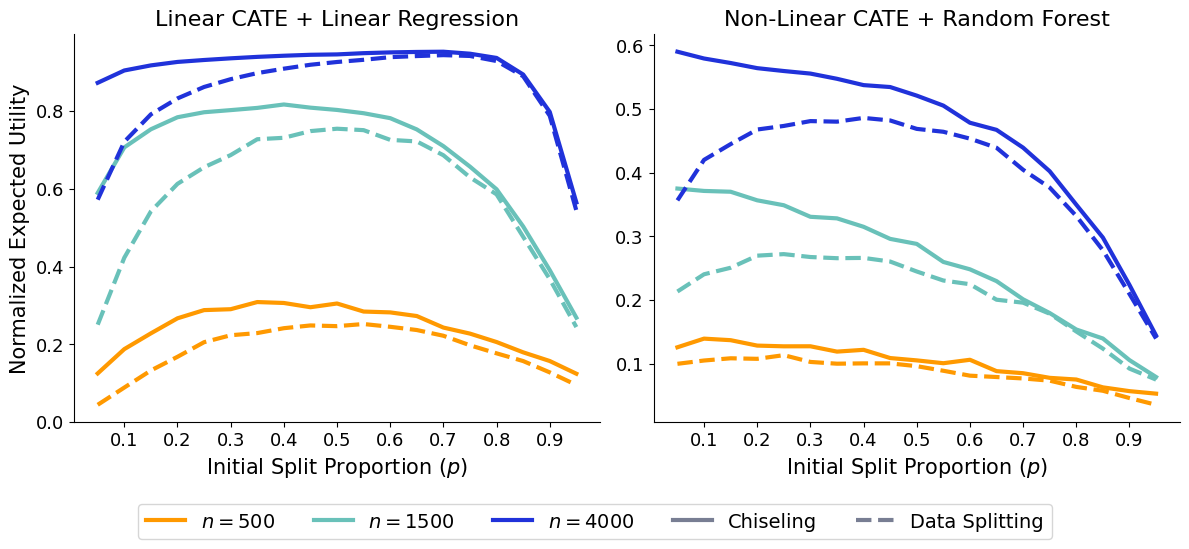

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

VIZ_PROPERTY = "norm_subgroup_utility_mean"
YLABEL = "Normalized Expected Utility"
PLOT_SAVELABEL = "utility"

n_space = sorted(agg_res_df.n.unique())
ratio_space = sorted(agg_res_df.n_burn_in.dropna().unique())



# ---------------------------------------- PLOTTING ---------------------------------------- #

n_legend_handles = []
for n in n_space:
    ### LINEAR ###
    sub_df = agg_res_df[agg_res_df.n == n]
    # Chiseling
    sub_sub_df = sub_df[sub_df.strategy == "Chiseling"].set_index("n_burn_in").loc[ratio_space]
    ax[0].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
               label="$n = {}$".format(n), color=n_space_cmap[n], linewidth=LINEWIDTH)
    ax[0].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)
    # Data splitting
    sub_sub_df = sub_df[sub_df.strategy == "DataSplittingStrategy"].set_index("train_ratio").loc[ratio_space]
    ax[0].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
               linestyle=DASH_LINESTYLE, color=n_space_cmap[n], linewidth=LINEWIDTH)
    ax[0].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)
    ### KANG-SCHAFER ###
    sub_df = agg_ks_res_df[agg_ks_res_df.n == n]
    # Chiseling
    sub_sub_df = sub_df[sub_df.strategy == "Chiseling"].set_index("n_burn_in").loc[ratio_space]
    # Save the handle here for legend logic later
    handle, = ax[1].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                         label="$n = {}$".format(n), color=n_space_cmap[n], linewidth=LINEWIDTH)
    n_legend_handles.append(handle)
    ax[1].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)
    # Data splitting
    sub_sub_df = sub_df[sub_df.strategy == "DataSplittingStrategy"].set_index("train_ratio").loc[ratio_space]
    ax[1].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
               linestyle=DASH_LINESTYLE, color=n_space_cmap[n], linewidth=LINEWIDTH)
    ax[1].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)



# ---------------------------------------- LEGEND LOGIC ---------------------------------------- #

# Add some invisible dummy data to second panel to distinguish linestyles in plot
sub_df = agg_res_df[agg_res_df.n == n_space[0]]
# Chiseling
sub_sub_df = sub_df[sub_df.strategy == "Chiseling"].set_index("n_burn_in").loc[ratio_space]
ax[1].plot(ratio_space[0], sub_sub_df.loc[:,VIZ_PROPERTY].iloc[0],
           color=METHOD_LEGEND_COLOR, linestyle="-", linewidth=LINEWIDTH, label="Chiseling")
# Data splitting
sub_sub_df = sub_df[sub_df.strategy == "DataSplittingStrategy"].set_index("train_ratio").loc[ratio_space]
ax[1].plot(ratio_space[0], sub_sub_df.loc[:,VIZ_PROPERTY].iloc[0],
           color=METHOD_LEGEND_COLOR, linestyle=DASH_LINESTYLE, linewidth=LINEWIDTH, label="Data Splitting")
# Only get legend data for last panel
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[1].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=5)


# ---------------------------------------- GLOBAL FORMATTING ---------------------------------------- #
ax[0].set_xticks(np.linspace(0.1,0.9,9))
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
ax[0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
ax[0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title("Linear CATE + Linear Regression", fontsize=TITLE_FONTSIZE)

ax[1].set_xticks(np.linspace(0.1,0.9,9))
ax[1].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
ax[1].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title("Non-Linear CATE + Random Forest", fontsize=TITLE_FONTSIZE)

plt.tight_layout()



# ---------------------------------------- SAVE/DISPLAY ---------------------------------------- #

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

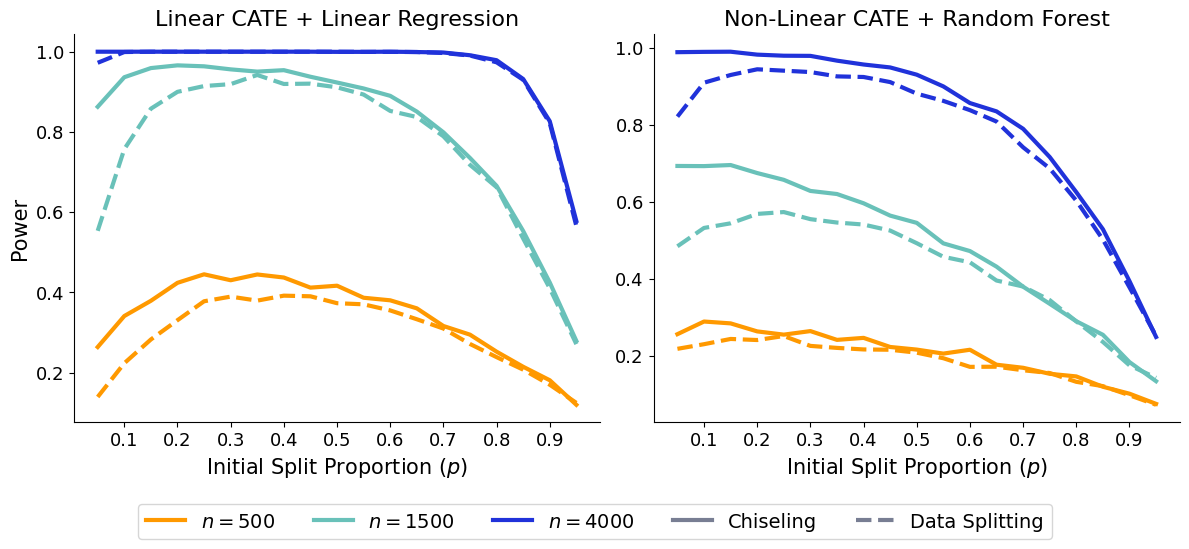

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

VIZ_PROPERTY = "rejected_mean"
YLABEL = "Power"
PLOT_SAVELABEL = "power"

n_space = sorted(agg_res_df.n.unique())
ratio_space = sorted(agg_res_df.n_burn_in.dropna().unique())



# ---------------------------------------- PLOTTING ---------------------------------------- #

n_legend_handles = []
for n in n_space:
    ### LINEAR ###
    sub_df = agg_res_df[agg_res_df.n == n]
    # Chiseling
    sub_sub_df = sub_df[sub_df.strategy == "Chiseling"].set_index("n_burn_in").loc[ratio_space]
    ax[0].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
               label="$n = {}$".format(n), color=n_space_cmap[n], linewidth=LINEWIDTH)
    ax[0].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)
    # Data splitting
    sub_sub_df = sub_df[sub_df.strategy == "DataSplittingStrategy"].set_index("train_ratio").loc[ratio_space]
    ax[0].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
               linestyle=DASH_LINESTYLE, color=n_space_cmap[n], linewidth=LINEWIDTH)
    ax[0].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)
    ### KANG-SCHAFER ###
    sub_df = agg_ks_res_df[agg_ks_res_df.n == n]
    # Chiseling
    sub_sub_df = sub_df[sub_df.strategy == "Chiseling"].set_index("n_burn_in").loc[ratio_space]
    # Save the handle here for legend logic later
    handle, = ax[1].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                         label="$n = {}$".format(n), color=n_space_cmap[n], linewidth=LINEWIDTH)
    n_legend_handles.append(handle)
    ax[1].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)
    # Data splitting
    sub_sub_df = sub_df[sub_df.strategy == "DataSplittingStrategy"].set_index("train_ratio").loc[ratio_space]
    ax[1].plot(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
               linestyle=DASH_LINESTYLE, color=n_space_cmap[n], linewidth=LINEWIDTH)
    ax[1].scatter(ratio_space, sub_sub_df.loc[:,VIZ_PROPERTY],
                  color=n_space_cmap[n], s=MARKERSIZE)



# ---------------------------------------- LEGEND LOGIC ---------------------------------------- #

# Add some invisible dummy data to second panel to distinguish linestyles in plot
sub_df = agg_res_df[agg_res_df.n == n_space[0]]
# Chiseling
sub_sub_df = sub_df[sub_df.strategy == "Chiseling"].set_index("n_burn_in").loc[ratio_space]
ax[1].plot(ratio_space[0], sub_sub_df.loc[:,VIZ_PROPERTY].iloc[0],
           color=METHOD_LEGEND_COLOR, linestyle="-", linewidth=LINEWIDTH, label="Chiseling")
# Data splitting
sub_sub_df = sub_df[sub_df.strategy == "DataSplittingStrategy"].set_index("train_ratio").loc[ratio_space]
ax[1].plot(ratio_space[0], sub_sub_df.loc[:,VIZ_PROPERTY].iloc[0],
           color=METHOD_LEGEND_COLOR, linestyle=DASH_LINESTYLE, linewidth=LINEWIDTH, label="Data Splitting")
# Only get legend data for last panel
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[1].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=5)


# ---------------------------------------- GLOBAL FORMATTING ---------------------------------------- #
ax[0].set_xticks(np.linspace(0.1,0.9,9))
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
ax[0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
ax[0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title("Linear CATE + Linear Regression", fontsize=TITLE_FONTSIZE)

ax[1].set_xticks(np.linspace(0.1,0.9,9))
ax[1].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
ax[1].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title("Non-Linear CATE + Random Forest", fontsize=TITLE_FONTSIZE)

plt.tight_layout()



# ---------------------------------------- SAVE/DISPLAY ---------------------------------------- #

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

### Type I error

Linear

In [18]:
setting_identifiers = ["n", "strategy", "n_burn_in", "train_ratio"]

In [19]:
task_array_path = "../../task_arrays/naive_chiseling_vs_naive_data_splitting.tasks.tsv"
res_path = "../../../output/naive_chiseling_vs_naive_data_splitting/naive_chiseling_vs_naive_data_splitting.combined.tsv"

In [20]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")
# Drop extreme ratios
res_df = res_df.loc[~res_df.n_burn_in.isin([0.01, 0.99])]
res_df = res_df.loc[~res_df.train_ratio.isin([0.01, 0.99])]

In [21]:
# Add error column
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [22]:
# Aggregate
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

In [23]:
# Subset to only chiseling methods
error_df = error_df[error_df.strategy == "Chiseling"]

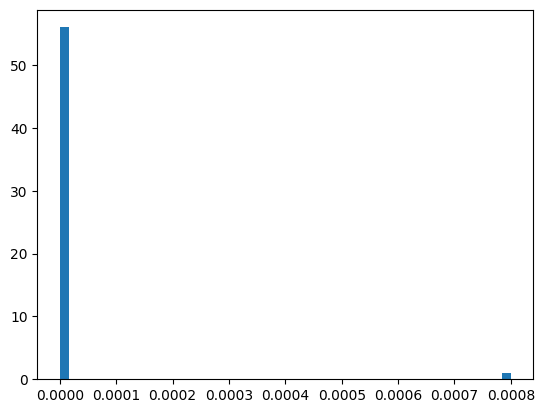

Min = 0.0 / Max = 0.0008


In [24]:
# Visualize here as a sanity check
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))

In [25]:
# Save
if SAVE:
    error_df.to_csv(TYPE1_ERROR_SAVEPATH + "{}_linear.{}.tsv".format(SAVELABEL, "t1e"), sep="\t", index=False)

Kang-Schafer

In [26]:
setting_identifiers = ["n", "strategy", "n_burn_in", "train_ratio"]

In [27]:
task_array_path = "../../task_arrays/naive_chiseling_vs_naive_data_splitting_kang_schafer.tasks.tsv"
res_path = "../../../output/naive_chiseling_vs_naive_data_splitting_kang_schafer/naive_chiseling_vs_naive_data_splitting_kang_schafer.combined.tsv"

In [28]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")
# Drop extreme ratios
res_df = res_df.loc[~res_df.n_burn_in.isin([0.01, 0.99])]
res_df = res_df.loc[~res_df.train_ratio.isin([0.01, 0.99])]

In [29]:
# Add error column
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [30]:
# Aggregate
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

In [31]:
# Subset to only chiseling methods
error_df = error_df[error_df.strategy == "Chiseling"]

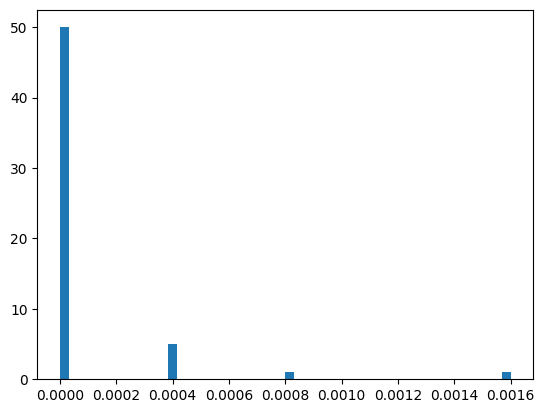

Min = 0.0 / Max = 0.0016


In [32]:
# Visualize here as a sanity check
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))

In [33]:
# Save
if SAVE:
    error_df.to_csv(TYPE1_ERROR_SAVEPATH + "{}_kang_schafer.{}.tsv".format(SAVELABEL, "t1e"), sep="\t", index=False)